In [1]:
import warnings
warnings.simplefilter(action='ignore',)

import multiprocessing
import multiprocessing as mp
from multiprocessing import Queue
print("Number of cpu : ", multiprocessing.cpu_count())

Number of cpu :  12


In [2]:
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit_machine_learning.kernels import QuantumKernel
quantum_instance = QuantumInstance(Aer.get_backend('qasm_simulator'), shots=128)

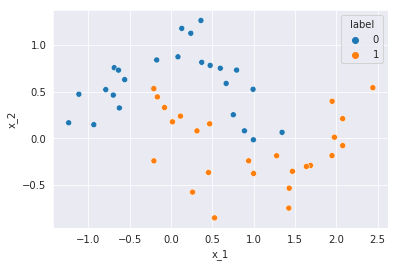

In [3]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors

from time import time
from circuit import generate_circuit

import seaborn as sns
from sklearn import datasets
from sklearn.svm import SVC
sns.set_style("darkgrid")

##### Toy data #####
X,y = datasets.make_moons(n_samples=50, noise=0.2, random_state=7)
moon_data = pd.DataFrame(dict(x_1=X[:,0], x_2=X[:,1], label=y))

sns.scatterplot('x_1', 'x_2', data=moon_data, hue='label')
plt.show()

from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(X, y, random_state = 42,test_size=1/5)

##### Parameters

In [4]:
QUBIT = 2
FEATURE = 2

BIT = 5
GENE = 10
# POPULATION = 10
POPULATION = multiprocessing.cpu_count() 

POOLSIZE = 4
OFFSPRINGSIZE = POPULATION - POOLSIZE

PROB = 8
MUTATION_PROB = PROB/POPULATION

GENERATION = 30

##### Multi-objective fitness function


In [5]:
def cost_func(acc, one, two): 
    
    if acc == 0.0: acc = 0.01

    gate_size = one + 2*two
    fit = gate_size + 20 / acc**2 - 20

    return round(fit,1)

In [6]:
def calculate_fitness(pop, population, train_x, train_y, test_x, test_y):
    FITNESS = []
    SCORE, ONE, TWO = [], [], []

    for i in range(population):
        qc_i, one_i, two_i = generate_circuit(pop[i], QUBIT, FEATURE)
        kernel = QuantumKernel(feature_map=qc_i, quantum_instance=quantum_instance,)
        model = SVC(kernel=kernel.evaluate)
        model.fit(train_x, train_y)
        score = model.score(test_x, test_y)
        
        SCORE.append(score)
        ONE.append(one_i)
        TWO.append(two_i)

    for i in range(population):
        fit = cost_func(SCORE[i], ONE[i], TWO[i])
        FITNESS.append(fit)
    
    return SCORE, FITNESS

#### Genetic Algorithm

In [7]:
pop = []

for i in range(POPULATION):
    genes = np.random.randint(2, size=(GENE,BIT))
    pop.append(genes)
    
def task(i, pop, q):
    qc_i, one_i, two_i = generate_circuit(pop[i], QUBIT, FEATURE)
    kernel = QuantumKernel(feature_map=qc_i, quantum_instance=quantum_instance,)
    model = SVC(kernel=kernel.evaluate)
    model.fit(train_x, train_y)
    score = model.score(test_x, test_y)
    q.put([score, one_i, two_i])
    
start_time = time()
for g in range(GENERATION):

    ##### Don't use if you don't have multiple CPU #####
    inputs = range(POPULATION)
    process_list= []
    q_list = [Queue() for i in range(len(inputs))]
    RESULt = []

    for i in inputs:
        process_list.append(mp.Process(target = task, args = (i, pop,  q_list[i])))
        process_list[-1].start()

    for i in inputs:
        process_list[i].join()

    for q in q_list:
        RESULt.append(q.get())

    FITNESS = []
    SCORE, ONE, TWO = [], [], []

    for i in range(POPULATION):
        SCORE.append(RESULt[i][0])
        ONE.append(RESULt[i][1])
        TWO.append(RESULt[i][2])

    for i in range(POPULATION):
        fit = cost_func(SCORE[i], ONE[i], TWO[i])
        FITNESS.append(fit)     
    ##### Don't use if you don't have multiple CPU #####
    ##### Run line below instead
    
    # SCORE, FITNESS = calculate_fitness(pop, POPULATION, train_x, train_y, test_x, test_y)
    
    end_time = time()

    print("\nGeneration:", g+1,", Cost time: {:3f} s".format(end_time-start_time))
    print("Accuracy:", SCORE)
    print("Fitness:", FITNESS)

    if g == GENERATION: break

    parents = []
    for i in range(POOLSIZE):
        FitnessIndex = np.where(FITNESS == min(FITNESS))
        parents.append(pop[FitnessIndex[0][0]])
        del FITNESS[FitnessIndex[0][0]]
        del pop[FitnessIndex[0][0]]


    for i in range(OFFSPRINGSIZE):
        ll,rr = np.random.randint(POOLSIZE), np.random.randint(POOLSIZE)
        parent_left, parent_right = parents[ll], parents[rr]
        cross_point = np.random.randint(GENE-1) 
        offspring = np.concatenate((parent_left[:cross_point],parent_right[cross_point:]), axis=0)

        for ii in range(PROB):
            mutation_index = np.random.randint(GENE) 
            mutation_bit = np.random.randint(BIT) 
            offspring[mutation_index][mutation_bit] = (offspring[mutation_index][mutation_bit]+1)%2

        parents.append(offspring)
        
    pop = parents


Generation: 1 , Cost time: 17.183943 s
Accuracy: [1.0, 0.6, 0.9, 0.6, 0.7, 0.2, 0.2, 1.0, 0.5, 0.6, 0.2, 0.2]
Fitness: [7.0, 43.6, 13.7, 44.6, 27.8, 485.0, 487.0, 11.0, 65.0, 41.6, 487.0, 484.0]

Generation: 2 , Cost time: 35.236257 s
Accuracy: [1.0, 1.0, 0.9, 0.7, 0.8, 0.8, 0.8, 0.7, 0.8, 0.8, 0.6, 0.6]
Fitness: [7.0, 11.0, 13.7, 27.8, 18.2, 21.2, 16.2, 27.8, 16.2, 21.2, 44.6, 42.6]

Generation: 3 , Cost time: 54.490249 s
Accuracy: [1.0, 1.0, 0.9, 0.7, 0.5, 0.6, 0.7, 0.7, 0.9, 0.9, 0.7, 0.9]
Fitness: [7.0, 11.0, 13.7, 25.8, 70.0, 44.6, 29.8, 30.8, 11.7, 12.7, 25.8, 11.7]

Generation: 4 , Cost time: 73.771451 s
Accuracy: [1.0, 1.0, 0.9, 0.9, 0.5, 0.7, 0.6, 1.0, 0.8, 1.0, 0.7, 1.0]
Fitness: [7.0, 11.0, 11.7, 11.7, 68.0, 29.8, 39.6, 7.0, 19.2, 8.0, 27.8, 8.0]

Generation: 5 , Cost time: 92.618885 s
Accuracy: [0.9, 0.9, 1.0, 0.9, 0.6, 0.6, 0.8, 0.7, 1.0, 0.7, 0.6, 0.6]
Fitness: [11.7, 11.7, 8.0, 12.7, 43.6, 44.6, 19.2, 28.8, 6.0, 26.8, 42.6, 41.6]

Generation: 6 , Cost time: 110.999867 s

#### Results

one gates: 3 
two gates: 0


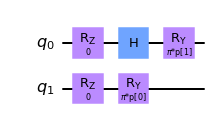

In [8]:
DISPLAY = 1
qc_display, one_display, two_display = generate_circuit(pop[DISPLAY-1], QUBIT, FEATURE)
print("one gates:",one_display,"\ntwo gates:",two_display)
qc_display.draw(output="mpl")

In [9]:
ga_kernel = QuantumKernel(feature_map=qc_display, quantum_instance=quantum_instance,)
model_ga = SVC(kernel=ga_kernel.evaluate)
qsvm = model_ga.fit(train_x, train_y)
q_score = model_ga.score(test_x, test_y)

print(f'Quantum kernel acc: {q_score}')

Quantum kernel acc: 1.0


#### Compare kernels

In [10]:
margin = 0.24

def make_meshgrid(x, y, h=0.004):
    x_min, x_max = x.min() - margin, x.max() + margin
    y_min, y_max = y.min() - margin, y.max() + margin
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def make_big_meshgrid(x, y, h=0.1): # 0.08
    x_min, x_max = x.min() - margin, x.max() + margin
    y_min, y_max = y.min() - margin, y.max() + margin
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

X0, X1 = X[:, 0], X[:, 1]

xx, yy = make_meshgrid(X0, X1)
bbxx, bbyy = make_big_meshgrid(X0, X1)

meshgrid_features = np.column_stack((xx.ravel(), yy.ravel()))
bbmeshgrid_features = np.column_stack((bbxx.ravel(), bbyy.ravel()))

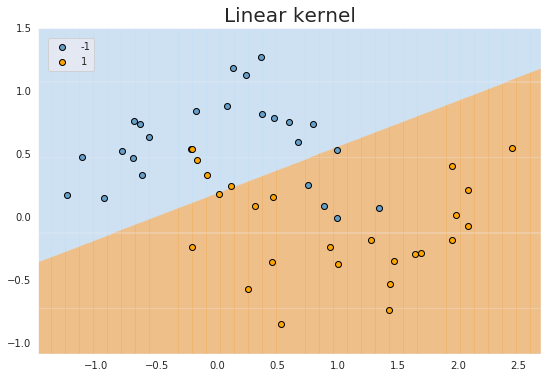

SVM linear test score: 0.7


In [11]:
model_svc = SVC(kernel='linear')
svc_l = model_svc.fit(train_x, train_y)
score = model_svc.score(test_x, test_y)

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#ADDFFF","#FF8C00"])
meshgrid_colors = svc_l.predict(meshgrid_features)

plt.figure(figsize=(9,6))
meshgrid_colors = meshgrid_colors.reshape(xx.shape)
plt.pcolormesh(xx, yy, meshgrid_colors, cmap=cmap, alpha=0.06)

plt.scatter(
    X[:, 0][y == 0],
    X[:, 1][y == 0],
    marker="o",
    facecolors="#659EC7",
    edgecolors="k",
    label="-1",)

plt.scatter(
    X[:, 0][y == 1],
    X[:, 1][y == 1],
    marker="o",
    facecolors="#FFA500",
    edgecolors="k",
    label="1",)

plt.legend( loc="upper left", borderaxespad=1.0)
plt.title("Linear kernel", fontsize=20)
plt.show()

print(f'SVM linear test score: {score}')

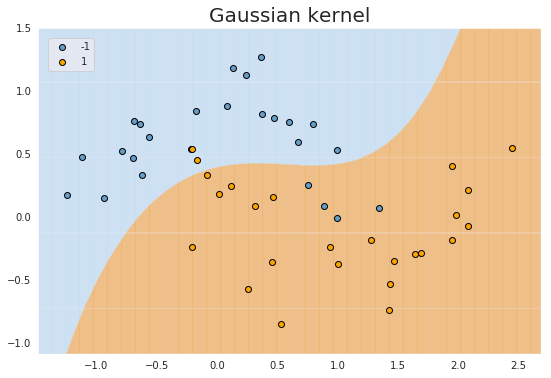

SVM Gaussian test score: 0.8


In [12]:
model_svc = SVC(kernel='rbf')
svc_p = model_svc.fit(train_x, train_y)
score = model_svc.score(test_x, test_y)

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#ADDFFF","#FF8C00"])
meshgrid_colors = svc_p.predict(meshgrid_features)

plt.figure(figsize=(9,6))
meshgrid_colors = meshgrid_colors.reshape(xx.shape)
plt.pcolormesh(xx, yy, meshgrid_colors, cmap=cmap, alpha=0.06)

plt.scatter(
    X[:, 0][y == 0],
    X[:, 1][y == 0],
    marker="o",
    facecolors="#659EC7",
    edgecolors="k",
    label="-1",)

plt.scatter(
    X[:, 0][y == 1],
    X[:, 1][y == 1],
    marker="o",
    facecolors="#FFA500",
    edgecolors="k",
    label="1",)

plt.legend( loc="upper left", borderaxespad=1.0)
plt.title("Gaussian kernel", fontsize=20)
plt.show()

print(f'SVM Gaussian test score: {score}')

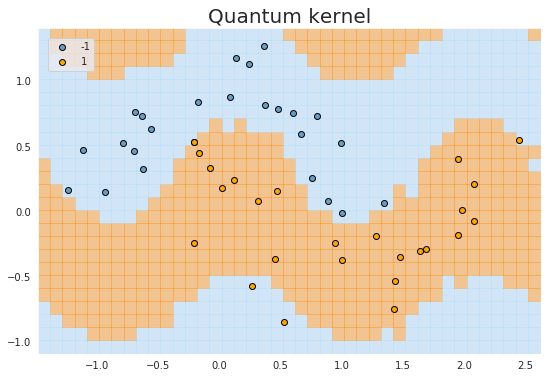

QSVM test score: 1.0


In [13]:
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#ADDFFF","#FF8C00"])
meshgrid_colors = qsvm.predict(bbmeshgrid_features)

plt.figure(figsize=(9,6))
meshgrid_colors = meshgrid_colors.reshape(bbxx.shape)
plt.pcolormesh(bbxx, bbyy, meshgrid_colors, cmap=cmap, alpha=0.4)

plt.scatter(
    X[:, 0][y == 0],
    X[:, 1][y == 0],
    marker="o",
    facecolors="#659EC7",
    edgecolors="k",
    label="-1",)

plt.scatter(
    X[:, 0][y == 1],
    X[:, 1][y == 1],
    marker="o",
    facecolors="#FFA500",
    edgecolors="k",
    label="1",)

plt.legend(loc="upper left", borderaxespad=1.0)
plt.title("Quantum kernel", fontsize=20)
plt.show()

print(f'QSVM test score: {q_score}')